In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import rosbag
import glob
import os
import rospy
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics

# read data(commented are the vicon topic names for other data )

In [2]:
data_path = './Robot_ViconOctober/'
#'/vicon/atag/atag---Aug tag name
#'/vicon/PEE/PEE' -- Nov tag name
#/vicon/packbot_endEff/packbot_endEff -- Oct tag name

# Extract static vicon, camera and joints data for calibration

Lets ignore the static data for now - there's clearly something wrong with it, so lets only look at dynamic data

In [13]:
# # Extract Vicon and camera stationary data
# ## Load Vicon data
# vicobags_stat = glob.glob(data_path+'ViconStationeryDataOct/*.bag') 
# for i,bag in enumerate(vicobags_stat): # loop over vicon bags
#     vsbag = rosbag.Bag(bag)
#     vicon_statXpos = []
#     vicon_statYpos = []
#     vicon_statZpos = []
#     for topicc, msgg, tt in vsbag.read_messages(topics=['/vicon/packbot_endEff/packbot_endEff']): # extract data
#         vicon_statXpos.append(msgg.transform.translation.x)
#         vicon_statYpos.append(msgg.transform.translation.y)
#         vicon_statZpos.append(msgg.transform.translation.z)  
#     vsbag.close()

#     vicon_statXPosArr = np.array(vicon_statXpos)
#     vicon_statYPosArr = np.array(vicon_statYpos)
#     vicon_statZPosArr = np.array(vicon_statZpos)
#     vicon_statPosArr = np.column_stack((vicon_statXPosArr,vicon_statYPosArr,vicon_statZPosArr)) 
#     np.save(data_path+'vicon_statPosArr_%d.npy'%i, vicon_statPosArr) # save to numpy

# # Load Robot data    
# robobags_stat = glob.glob(data_path+'RobotStationeryDataOct/*.bag')
# for i,bag in enumerate(robobags_stat): # loop over robot bags
#     rsbag = rosbag.Bag(bag)
#     robot_statXpos = []
#     robot_statYpos = []
#     robot_statZpos = []
#     robotbag_Tagtime_stat = []
#     for topi, msgs, tym in rsbag.read_messages(topics=['/tag_detections']): # extract data
#         try:
#             robot_statXpos.append(msgs.detections[0].pose.pose.pose.position.x)
#             robot_statYpos.append(msgs.detections[0].pose.pose.pose.position.y)
#             robot_statZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
#             robotbag_Tagtime_stat.append(t.secs)
#         except:
#             continue
#     #rsbag.close()
#     robot_statXposArr = np.array(robot_statXpos)
#     robot_statYposArr = np.array(robot_statYpos)
#     robot_statZposArr = np.array(robot_statZpos)
#     robot_statposArr = np.column_stack((robot_statXposArr,robot_statYposArr,robot_statZposArr))
#     np.save(data_path+'robot_statPosArr_%d.npy'%i, robot_statposArr)
    
#     robotbag_Jointstime_stat = []
#     ja_list = []
#     for topic2, msg2, t2 in rsbag.read_messages(topics=['/Packbot510/joints']):
#         ja_list.append(msg2.position[:3])
#         robotbag_Jointstime_stat.append(t2.secs)
#     ja_array_stat = np.array(ja_list)
#     rsbag.close()
#     np.save(data_path+'ja_array_stat%d.npy'%i, ja_array_stat)                         


# Loading the saved  static data 

In [4]:
# kinematics_list = []
# vicon_list = []
# camera_list = []
# for i in range(len(vicobags_stat)):
#     vicon = np.load(data_path+'vicon_statPosArr_%d.npy'%i)
#     vicon_list.append(vicon)
    
#     RobotKin = np.load(data_path+'ja_array_stat%d.npy'%i)
#     kinematics_list.append(RobotKin)
    
#     robot = np.load(data_path+'robot_statPosArr_%d.npy'%i)
#     camera_list.append(robot)

# use the joints data for kinematics (static)

In [5]:
# robot = URDF.from_xml_file('robot.urdf')
# links = [rl.name for rl in robot.links]
# kdl_kin = KDLKinematics(robot,'base_link','elbow2_link')
# #print(kdl_kin.get_joint_names())

# BaseTo_ee_xyz = []
# for d in kinematics_list:
#     ee_list = []
#     for joint in d:
#         posez = kdl_kin.forward(joint)
#         ee_list.append(posez[0:3,3])
#     BaseTo_ee_xyz.append(np.squeeze(np.array(ee_list)))
# np.save(data_path+'BaseTo_ee_xyz%d.npy'%i, BaseTo_ee_xyz)

# Create procrustes function to use later

In [6]:
# Create procrustes function to use later
def procrustes(matx1,matx2):

    # translate all the data to the origin
    mean1 =  np.mean(matx1, 0)
    mean2 =  np.mean(matx2, 0)
    matx1 -= mean1
    matx2 -= mean2

    norm1 = np.linalg.norm(matx1)
    norm2 = np.linalg.norm(matx2)

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    matx1 /= norm1
    matx2 /= norm2

    L,D,M = np.linalg.svd(matx1.T.dot(matx2))
    
    s = np.sum(D)*norm1/norm2

    Rot = L.dot(M)
    tra = mean1 - (s*np.dot(Rot,mean2.T)).T

    return Rot, tra.reshape(-1,1), s

# Calibrating vicon and camera

This doesn't do anything remember - it makes no sense to try calibrate these two - because the camera moves with the arm. So I'd get rid of this and the block below.

Procrustes finds a rigid transform between two fixed frames. But when the camera frame is moving, it can never work because the transform is never fixed.


In [12]:
# Get means 
# vicon_means = [np.mean(d,axis=0) for d in vicon_list]
# camera_means = [np.mean(d,axis=0) for d in camera_list]

# Rot_VandCam, trans_VandCam,scale_VandCam = procrustes(np.array(vicon_means),np.array(camera_means))
# print(Rot_VandCam)
# print(trans_VandCam)
# print(scale_VandCam) # should be close to 1 for good data

# # Save calibration parameters for use in dynamics analysis

# np.save(data_path+'Rot_VandCam.npy',Rot_VandCam)
# np.save(data_path+'trans_VandCam.npy',trans_VandCam)
# np.save(data_path+'scale_VandCam.npy',scale_VandCam)

# Rotate camera data into Vicon frame of reference
# camera_v_list = [scale_VandCam*np.dot(Rot_VandCam,d.T).T + trans_VandCam.T for d in camera_list]

[[-0.94471729  0.18102871  0.27338224]
 [-0.28272685 -0.87200987 -0.39958017]
 [ 0.16605653 -0.45478279  0.87498448]]
[[ 0.39983824]
 [ 0.0546991 ]
 [ 0.18974951]]
1.08471808735


# Calibrating vicon and End_effector kinematics

In [8]:
# # Get means 
# vicon_means = [np.mean(d,axis=0) for d in vicon_list]
# kinematics_means = [np.mean(d,axis=0) for d in BaseTo_ee_xyz]

# Rot_VandKin, trans_VandKin,scale_VandKin = procrustes(np.array(vicon_means),np.array(kinematics_means))
# print(Rot_VandKin)
# print(trans_VandKin)
# print(scale_VandKin) # should be close to 1 for good data

# # Save calibration parameters for use in dynamics analysis

# np.save(data_path+'Rot_VandKin.npy',Rot_VandKin)
# np.save(data_path+'trans_VandKin.npy',trans_VandKin)
# np.save(data_path+'scale_VandKin.npy',scale_VandKin)

# # Rotate Kdl_kinematics data into Vicon frame of reference
# kinematics_v_list = [scale_VandCam*np.dot(Rot_VandCam,d.T).T + trans_VandCam.T for d in BaseTo_ee_xyz]

[[ 0.91087389  0.41180292  0.02696483]
 [-0.41198285  0.91119076  0.00123909]
 [-0.02405985 -0.01223771  0.99963561]]
[[ 0.07025101]
 [ 0.18596177]
 [-0.04139798]]
0.977391329043


# Extract Vicon and camera dynamic data

This should be done once, in a different notebook. Once you have extracted and saved the data in a nice format, you never need to extract it again.

In [18]:
import glob
glob.glob(data_path+'/RobotDynamicDataOct/*')

['./Robot_ViconOctober//RobotDynamicDataOct/subsetD0.bag',
 './Robot_ViconOctober//RobotDynamicDataOct/subsetD3.bag',
 './Robot_ViconOctober//RobotDynamicDataOct/subsetD1.bag',
 './Robot_ViconOctober//RobotDynamicDataOct/subsetD2.bag']

In [23]:
# Extract Vicon and camera dynamic data
## Load Vicon data
vicobags_dyna = glob.glob(data_path+'ViconDynamicDataOct/*.bag')
for i,bag in enumerate(vicobags_dyna): # loop over vicon bags
    vdbag = rosbag.Bag(bag)
    vicon_dynaXpos = []
    vicon_dynaYpos = []
    vicon_dynaZpos = []
    viconbag_time_dyna = []
    for topicc, msgg, tt in vdbag.read_messages(topics=['/vicon/packbot_endEff/packbot_endEff']): # extract data
        vicon_dynaXpos.append(msgg.transform.translation.x)
        vicon_dynaYpos.append(msgg.transform.translation.y)
        vicon_dynaZpos.append(msgg.transform.translation.z) 
        vicon_time_dy = tt.secs
        viconbag_time_dyna.append(vicon_time_dy)
    vdbag.close()

    vicon_dynaXPosArr = np.array(vicon_dynaXpos)
    vicon_dynaYPosArr = np.array(vicon_dynaYpos)
    vicon_dynaZPosArr = np.array(vicon_dynaZpos)
    vicon_dynaPosArr = np.column_stack((vicon_dynaXPosArr,vicon_dynaYPosArr,vicon_dynaZPosArr)) 
    np.save(data_path+'vicon_dynaPosArr%d.npy'%i, vicon_dynaPosArr) # save to numpy
    np.save(data_path+'viconbag_time_dyna%d.npy'%i, viconbag_time_dyna)
    
# Load Robot data    
robobags_dyna = glob.glob(data_path+'RobotDynamicDataOct/*.bag')
for i,bag in enumerate(robobags_dyna): # loop over robot bags
    rdbag = rosbag.Bag(bag)
    robot_dynaXpos = []
    robot_dynaYpos = []
    robot_dynaZpos = []
    robotbag_Tagtime_dyna = [] # \this was spelt wrong
    for topi, msgs, tym in rdbag.read_messages(topics=['/tag_detections']): # extract data
        try:
            robot_dynaXpos.append(msgs.detections[0].pose.pose.pose.position.x)
            robot_dynaYpos.append(msgs.detections[0].pose.pose.pose.position.y)
            robot_dynaZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
            robotbag_Tagtime_dyna.append(tym.secs)
        except:
            continue

    robot_dynaXposArr = np.array(robot_dynaXpos)
    robot_dynaYposArr = np.array(robot_dynaYpos)
    robot_dynaZposArr = np.array(robot_dynaZpos)
    robot_dynaposArr = np.column_stack((robot_dynaXposArr,robot_dynaYposArr,robot_dynaZposArr))
    np.save(data_path+'robot_dynaPosArr%d.npy'%i, robot_dynaposArr)
    np.save(data_path+'robotbag_Tagtime_dyna%d.npy'%i, robotbag_Tagtime_dyna)
    
    
    robotbag_Jointstime_dyna = []
    ja_list = []
    for topic2, msg2, t2 in rdbag.read_messages(topics=['/Packbot510/joints']):
        ja_list.append(msg2.position[:3])
        robotbag_Jointstime_dyna.append(t2.secs)
    ja_array_dyna = np.array(ja_list)
    rdbag.close()
    np.save(data_path+'ja_array_dyna%d.npy'%i, ja_array_dyna)
    np.save(data_path+'robotbag_Jointstime_dyna%d.npy'%i, robotbag_Jointstime_dyna)

# Loading the saved dynamic data

In [28]:
# Sanity check loading data we just saved
vicon_dylist = []
camera_dylist = []
kinematics_list_dyna = []

tk = []
tc = []
tv = []

for i in range(len(vicobags_dyna)):
    vicon_dy = np.load(data_path+'vicon_dynaPosArr%d.npy'%i)
    vicon_dylist.append(vicon_dy)
    v_time = np.load(data_path+'viconbag_time_dyna%d.npy'%i) # Name was wrong. missing dyna
    tv.append(v_time)
   
    robot_dy = np.load(data_path+'robot_dynaPosArr%d.npy'%i)
    camera_dylist.append(robot_dy)
    c_time = np.load(data_path+'robotbag_Tagtime_dyna%d.npy'%i) # Name was wrong. missing dyna
    tc.append(c_time)
    
    RobotKin_dy = np.load(data_path+'ja_array_dyna%d.npy'%i)
    kinematics_list_dyna.append(RobotKin_dy)
    k_time = np.load(data_path+'robotbag_Jointstime_dyna%d.npy'%i)
    tk.append(k_time)
    
# NB: your naming conventions are sloppy, which introduces incosistency and errors, try to be simple and stick to the same conventions throughout. 
# Even when you label your data/ bag files. It makes your life easier, and you spend less time wasting on issues like this. It's shorter to spend more time organising your code and files 
# than to figuring out what is going wrong in a mess.

# use the joints data for kinematics (dynamic) : yes, we need them

In [29]:
robot = URDF.from_xml_file('robot.urdf')
links = [rl.name for rl in robot.links]
kdl_kin_dy = KDLKinematics(robot,'base_link','elbow2_link')
#print(kdl_kin.get_joint_names())

BaseTo_ee_xyz_dyna = []
for dy in kinematics_list_dyna:
    ee_list_dy = []
    for joints in dy:
        posez_dy = kdl_kin_dy.forward(joints)
        ee_list_dy.append(posez_dy[0:3,3])
    BaseTo_ee_xyz_dyna.append(np.squeeze(np.array(ee_list_dy)))
np.save(data_path+'BaseTo_ee_xyz_dyna%d.npy'%i, BaseTo_ee_xyz_dyna)

# Transform camera and ee_kin dyanmic data use the calibration matrices from static data

For now we are just looking at the data - no calibration. To see if it followed the same path. Ignore the calibration

In [30]:
# camera_in_vicon = []
# BaseToEndEff_in_vicon = []
# for i in range(len(vicon_dylist)):
#     cameraDynamicdata_trans =np.dot(Rot_VandCam,camera_dylist[i].T) + trans_VandCam
#     camera_in_vicon.append(cameraDynamicdata_trans.T)
    
#     kinematicsDynamicdata_trans =np.dot(Rot_VandKin,BaseTo_ee_xyz_dyna[i].T) + trans_VandKin
#     BaseToEndEff_in_vicon.append(kinematicsDynamicdata_trans.T)

# Plot untransformed vicon vs camera vs ee_kin

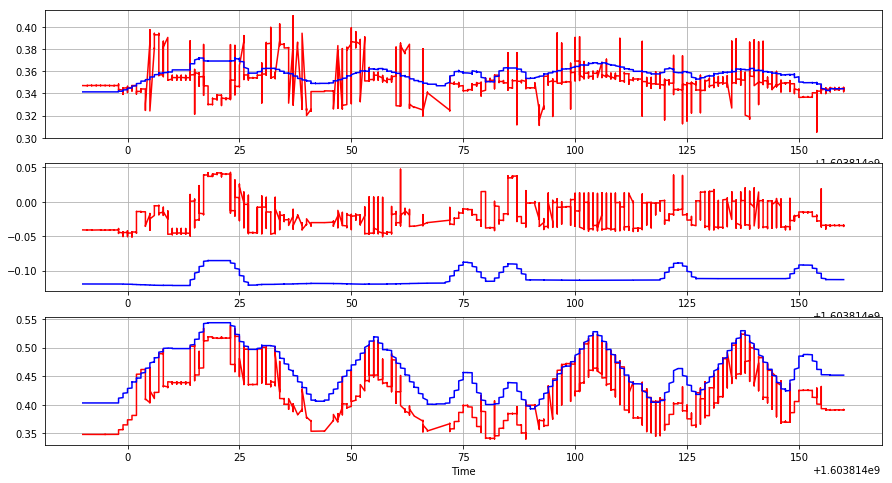

In [36]:

fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()

#Plot vicon data
axs[0].plot((tv[3]),vicon_dylist[3][:,0],c='r')
axs[1].plot((tv[3]),vicon_dylist[3][:,1],c='r')
axs[2].plot((tv[3]),vicon_dylist[3][:,2],c='r')

# #Plot camera data - I don't think camera data tells us much - so ignore it for now
# axs[0].plot((tc[3]),camera_dylist[3][:,0],c='g')
# axs[1].plot((tc[3]),camera_dylist[3][:,1],c='g')
# axs[2].plot((tc[3]),camera_dylist[3][:,2],c='g')

#Plot kinematics data
axs[0].plot((tk[3]),BaseTo_ee_xyz_dyna[3][:,0],c='b') # Standardardise your naming conventions. - you were missing the dyna
axs[1].plot((tk[3]),BaseTo_ee_xyz_dyna[3][:,1],c='b') # I like the vicon_dylist, camera_dy_list version above
axs[2].plot((tk[3]),BaseTo_ee_xyz_dyna[3][:,2],c='b')

# Remember what I said about axis limits? Where are they?!

# Why are you plotting the 3rd bag for vicon, and the 1st bag for robot ee? Were they unsorted?

#So nothing is lined up (we don't expect it to be) - and it doesn't look easy to see. We will need a 3D plot of the trajectories.

plt.show()

# Plot vicon vs  transformed camera vs transformed ee_kin

NameError: name 'tv' is not defined

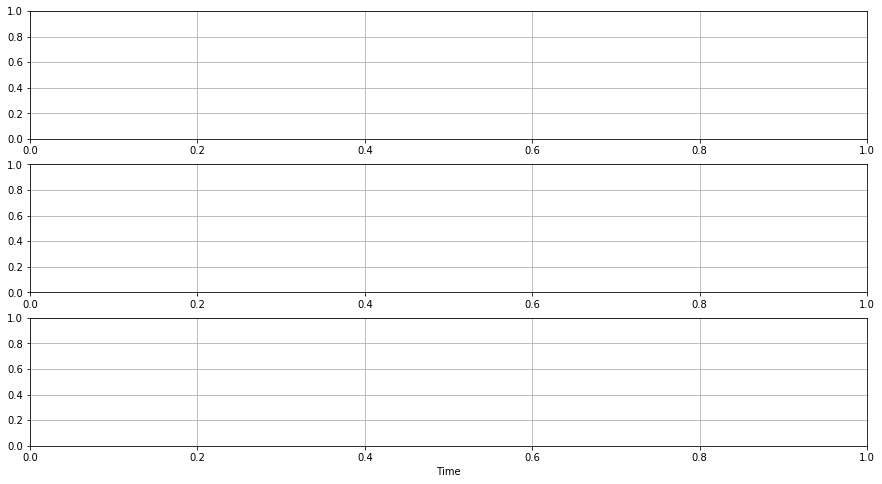

In [11]:


# fig, axs = plt.subplots(3,figsize =(15,8))
# plt.xlabel('Time')
# axs[0].grid()
# axs[1].grid()
# axs[2].grid()

# #Plot vicon data
# axs[0].plot((tv[3]),vicon_dylist[3][:,0],c='r')
# axs[1].plot((tv[3]),vicon_dylist[3][:,1],c='r')
# axs[2].plot((tv[3]),vicon_dylist[3][:,2],c='r')

# #Plot camera data
# axs[0].plot((tc[3]),camera_in_vicon[3][:,0],c='g')
# axs[1].plot((tc[3]),camera_in_vicon[3][:,1],c='g')
# axs[2].plot((tc[3]),camera_in_vicon[3][:,2],c='g')

# #Plot kinematics data
# axs[0].plot((tk[3]),BaseToEndEff_in_vicon[3][:,0],c='b')
# axs[1].plot((tk[3]),BaseToEndEff_in_vicon[3][:,1],c='b')
# axs[2].plot((tk[3]),BaseToEndEff_in_vicon[3][:,2],c='b')

# plt.show()